What are we going to do?\
We need to load the chosen/best models for all objects.\
We need to load the test samples for the objects.
we need to run all samples under each model and obtain the error estimation.\
This can be done with different time predictions (starting with 3/2/1 last seconds)\
After we have all error estimations - classify each sample\
evaluate accuracy etc. vs labels.

###Imports

In [ ]:
!pip install "pandas<2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 15.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [ ]:
# imports

import io
import glob
import os
import sys
from datetime import datetime
from time import time
import pickle
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
# from scipy.fft import fft
import pandas as pd
from itertools import product
import seaborn as sns
import random
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

!pip install einops
# from __future__ import annotations
from dataclasses import dataclass
from einops import rearrange, repeat, einsum

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# prompt: Access a folder on google drive and import the data locally
from google.colab import drive
drive.mount('/content/drive/')
# helper files
sys.path.append('/content/drive/MyDrive/Final Project UAV/')
from UAV_project_preprocessing_and_visualization_helper_functions_full import *
from mamba_model import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 986.9 kB/s eta 0:00:00
Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


In [ ]:
subfolders = os.listdir("track_data/")
subf_dict = {i:subfolders[i] for i in range(len(subfolders))}
labels_dict = {subfolders[i]:i for i in range(len(subfolders))}

###preparing test and validation samples

In [ ]:
# Here we combine the test samples from all different objects (subfolders)
# Each sample duration is combined separately so that we can evaluate separately for each duration
# The model returns the error averaged over the predictions of the last 3 sec of the sequence
# For example - a 5 sec sample would have 2 sec of input sequence without evaluation, and the error will be averaged over the last 3.
# For example - a 30 sec sample would have 27 sec of input sequence without evaluation, and the error will be averaged over the last 3.

subfolders = ['airplane', 'uav', 'bird', 'static-object']
# subfolders = ['uav', 'bird']
skips = [15, 15, 2, 40]
# skips = [15, 2]
durations = [5, 10, 15, 20, 25, 30]
batch_size = 1

all_test_batches = {d:[] for d in durations}
all_test_labels = {d:[] for d in durations}
all_val_batches = {d:[] for d in durations}
all_val_labels = {d:[] for d in durations}
for subfolder, skip in zip(subfolders, skips):
  # save_path = './Samples/mamba_samples_' + subfolder +'_skip'+ str(skip) +'_split0.2'+ '_all_samples'
  # save_path = './Samples/mamba_samples_' + subfolder +'_skip'+ str(skip) +'_split0.16'+ '_all_samples'
  # save_path = './Samples/mamba_samples_' + subfolder + '_skip' + str(skip) +'_split0.2' + '_val_test_raw_samples'
  save_path = './Samples/mamba_samples_' + subfolder + '_skip' + str(skip) +'_split0.2' + '_val_test_interp_samples'
  with open(save_path , 'rb') as f:
    (subfolder_train_data, subfolder_val_data, subfolder_test_data) = pickle.load(f)
    # (subfolder_val_data, subfolder_test_data) = pickle.load(f)
    for dur, (samples, samples_filenames, dt, scales) in subfolder_test_data.items():
      if len(samples) > 0:
        subfolder_batches = []
        subfolder_labels = []
        dur_vec = [dur]*len(samples)
        data = list(zip(samples, dt, scales, dur_vec))

        dl = DataLoader(data, batch_size = batch_size, shuffle = False)
        for batch in dl:
          subfolder_batches.append(batch)

        # Note that the batches are not full so the labels are added as the original number of samples and not based on the number of batches
        subfolder_labels.extend([labels_dict[subfolder]] * len(samples))
        all_test_batches[dur].extend(subfolder_batches)
        all_test_labels[dur].extend(subfolder_labels)


    for dur, (samples, samples_filenames, dt, scales) in subfolder_val_data.items():
      if len(samples) > 0:
        subfolder_batches = []
        subfolder_labels = []
        dur_vec = [dur]*len(samples)
        data = list(zip(samples, dt, scales, dur_vec))

        dl = DataLoader(data, batch_size = batch_size, shuffle = False)
        for batch in dl:
          subfolder_batches.append(batch)

        # Note that the batches are not full so the labels are added as the original number of samples and not based on the number of batches
        subfolder_labels.extend([labels_dict[subfolder]] * len(samples))
        all_val_batches[dur].extend(subfolder_batches)
        all_val_labels[dur].extend(subfolder_labels)

###Evaluation class

In [ ]:
class Evaluating(object):

  def __init__(self, model, config):
    self.config = config
    self.device = config['device']
    self.model = model.to(self.device)
    # self.model_path = config['model_path']
    self.criterion = nn.MSELoss(reduction='none').to(self.device)
    self.evaluation_length = int(config['evaluation_time']/config['delta'])
    self.evaluation_durations = config['evaluation_durations']
    # self.criterion = config['criterion'](weight = config['class_weights']).to(self.device)

  def evaluate(self, dl_eval):
    self.eval_results = {d:[] for d in self.evaluation_durations}
    self.epoch_eval_loss = 0

    self.model.eval() #evaluation mode
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=True):
        self.eval_batch(batch)

  def eval_batch(self, batch):
    data, dt, scale, dur = batch
    # Send tensors to GPU
    samples = data[:,:-1,:]
    labels = data[:,1:,:]
    samples = samples.to(self.device)
    labels = labels.to(self.device)
    dt = dt[:, :-1].to(self.device)
    scale = scale.to(self.device)

    predictions = self.model(samples, dt)#.type(torch.float64)#.type(torch.DoubleTensor)

    scaled_labels = einsum(labels, 1/scale, 'b l d, b d -> b l d')
    # print(scaled_labels)
    scaled_predictions = einsum(predictions, 1/scale, 'b l d, b d -> b l d')
    # print(scaled_predictions)
    eval_loss = self.criterion(scaled_predictions, scaled_labels)
    self.eval_results[int(dur[0])].extend(list((eval_loss[:, -self.evaluation_length:, :].mean((1,2))).cpu()))

    self.epoch_eval_loss += eval_loss.mean().item()

### loading models, running and receiving error

In [ ]:
field = 'Best Result @10'

In [ ]:
subfolders = ['airplane', 'uav', 'bird', 'static-object']
all_results_df = pd.DataFrame()
for subfolder in subfolders:
  prefix = './Mamba Training Results/mamba_training_results_split0.2_' + subfolder
  folder_results_df = pd.DataFrame()
  for file in glob.glob(prefix + '*'):
    print(file)
    with open(file, 'rb') as f:
      folder_results_df = folder_results_df.append(pickle.load(f))
  folder_results_df['Object'] = subfolder
  # best_model_row = folder_results_df.loc[folder_results_df['Best Result @5'].idxmin()]
  # all_results_df = all_results_df.append(best_model_row)
  all_results_df = all_results_df.append(folder_results_df)
  all_results_df = all_results_df.drop_duplicates(field)
best_models = all_results_df.groupby('Object').apply(lambda x: x[x[field] == x[field].min()])
saved_models_path = best_models[['Object', 'Model Path']].set_index('Object').to_dict()['Model Path']

./Mamba Training Results/mamba_training_results_split0.2_airplane04_04_2024, 10:17:14
./Mamba Training Results/mamba_training_results_split0.2_airplane04_10_2024, 16:08:04
./Mamba Training Results/mamba_training_results_split0.2_airplane04_10_2024, 16:51:44
./Mamba Training Results/mamba_training_results_split0.2_uav04_04_2024, 11:45:41
./Mamba Training Results/mamba_training_results_split0.2_uav04_11_2024, 04:57:09
./Mamba Training Results/mamba_training_results_split0.2_bird04_04_2024, 07:58:22
./Mamba Training Results/mamba_training_results_split0.2_bird04_04_2024, 08:32:41
./Mamba Training Results/mamba_training_results_split0.2_static-object04_04_2024, 13:50:05
./Mamba Training Results/mamba_training_results_split0.2_static-object04_11_2024, 10:15:52


In [ ]:
all_results_df

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results,Object
0,"04/04/2024, 09:56:52",560425,203240,235425,0.050,32,2,16,./Models/mamba_model_airplane_dm8nl2ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4225843.947368421, 3766551.3799342103, 336935...","[1372629.9775015025, 1187492.4270770734, 10263...","{5: [tensor(2009134.6250), tensor(1775395.), t...","{5: tensor(560425.7500), 10: tensor(203240.312...",airplane
1,"04/04/2024, 10:17:14",282335,195828,248199,0.010,64,1,16,./Models/mamba_model_airplane_dm8nl1ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 64, 'optimizer_type': <class 't...","[4246248.975, 3992137.15, 3741896.675, 3525284...","[1238016.1964285714, 1145974.049107143, 104862...","{5: [tensor(802754.0625), tensor(749276.8750),...","{5: tensor(282335.8750), 10: tensor(195828.203...",airplane
0,"04/10/2024, 16:08:04",214050,195370,349666,0.005,32,1,16,./Models/mamba_model_airplane_dm8nl1ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4600246.146381579, 4172647.755756579, 3780432...","[1243113.1310471755, 1094469.6147273136, 96192...","{5: [tensor(1044193.0625), tensor(932709.3125)...","{5: tensor(214050.9531), 10: tensor(195370.062...",airplane
1,"04/10/2024, 16:51:44",25951,24926,25643,0.010,32,2,16,./Models/mamba_model_airplane_dm8nl2ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4167401.966282895, 3774465.2976973685, 342633...","[1156171.3317307692, 1002759.4519230769, 87645...","{5: [tensor(966874.6875), tensor(850389.), ten...","{5: tensor(25951.9375), 10: tensor(24926.3535)...",airplane
0,"04/04/2024, 11:45:41",40271,33698,48598,0.010,32,1,16,./Models/mamba_model_uav_dm8nl1ds16dc4rs42bs32...,"[VIS_uav_20231027-10807_20231027-113911.json, ...","{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4814974.322916667, 4483031.84375, 4158378.135...","[4517158.426470588, 4206336.134191177, 3909674...","{5: [tensor(4828341.5000), tensor(4496202.), t...","{5: tensor(40271.0977), 10: tensor(33698.7148)...",uav
0,"04/11/2024, 04:57:09",3040,1931,3640,0.010,32,2,16,./Models/mamba_model_uav_dm8nl2ds16dc4rs42bs32...,"[VIS_uav_20231027-10807_20231027-113911.json, ...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4395118.354166667, 3713927.0520833335, 311597...","[4172366.2959558824, 3538994.6727941176, 29729...","{5: [tensor(4344296.), tensor(3685911.), tenso...","{5: tensor(3040.7278), 10: tensor(1931.6913), ...",uav
0,"04/04/2024, 07:58:22",2009,894,1236,0.050,32,2,16,./Models/mamba_model_bird_dm8nl2ds16dc4rs42bs3...,"[VIS_bird_20231116-20636_20231116-082324.json,...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[291574.09801136365, 255982.78941761365, 22666...","[229681.61830357142, 198624.72433035713, 17256...","{5: [tensor(206164.3125), tensor(178804.3281),...","{5: tensor(2009.7250), 10: tensor(894.1389), 1...",bird
1,"04/04/2024, 08:32:41",1630,1436,1515,0.010,32,2,16,./Models/mamba_model_bird_dm8nl2ds16dc4rs42bs3...,"[VIS_bird_20231116-20636_20231116-082324.json,...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[298195.3572443182, 261412.27272727274, 231447...","[227804.97433035713, 196908.66517857142, 17276...","{5: [tensor(210664.8750), tensor(182565.8594),...","{5: tensor(1630.289

In [ ]:
best_models

,,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results,Object
Object,,,,,,,,,,,,,,,,,,
airplane,1,"04/10/2024, 16:51:44",25951,24926,25643,0.01,32,2,16,./Models/mamba_model_airplane_dm8nl2ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4167401.966282895, 3774465.2976973685, 342633...","[1156171.3317307692, 1002759.4519230769, 87645...","{5: [tensor(966874.6875), tensor(850389.), ten...","{5: tensor(25951.9375), 10: tensor(24926.3535)...",airplane
bird,0,"04/04/2024, 07:58:22",2009,894,1236,0.05,32,2,16,./Models/mamba_model_bird_dm8nl2ds16dc4rs42bs3...,"[VIS_bird_20231116-20636_20231116-082324.json,...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[291574.09801136365, 255982.78941761365, 22666...","[229681.61830357142, 198624.72433035713, 17256...","{5: [tensor(206164.3125), tensor(178804.3281),...","{5: tensor(2009.7250), 10: tensor(894.1389), 1...",bird
static-object,0,"04/11/2024, 10:15:52",19819,23948,7809,0.01,32,2,16,./Models/mamba_model_static-object_dm8nl2ds16d...,[NIR_static-object_20231024-48984_20231024-234...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[13983462.18939394, 12031126.984848484, 103617...","[6284997.214285715, 5050981.761904762, 4145497...","{5: [tensor(9513625.), tensor(7972746.), tenso...","{5: tensor(19819.8145), 10: tensor(23948.6816)...",static-object
uav,0,"04/11/2024, 04:57:09",3040,1931,3640,0.01,32,2,16,./Models/mamba_model_uav_dm8nl2ds16dc4rs42bs32...,"[VIS_uav_20231027-10807_20231027-113911.json, ...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4395118.354166667, 3713927.0520833335, 311597...","[4172366.2959558824, 3538994.6727941176, 29729...","{5: [tensor(4344296.), tensor(3685911.), tenso...","{5: tensor(3040.7278), 10: tensor(1931.6913), ...",uav


####Evaluating all models on validation set with duration 10

In [ ]:
eval_dur = 10

In [ ]:
evaluation_config = {'batch_size': 1, 'device' : device, 'evaluation_time': 3, 'delta': 0.04, 'evaluation_durations': durations}
validation_results = {}
for i, row in all_results_df.iterrows():
  # print(row['Model Path'])
  # print(row['Mamba Config'])
  model_path = row['Model Path']
  state = torch.load(model_path, map_location=torch.device('cpu'))

  mamba_config = row['Mamba Config']
  # mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  mamba_model.load_state_dict(state['state_dict'])

  evaluating_mamba = Evaluating(mamba_model, evaluation_config)
  evaluating_mamba.evaluate(all_val_batches[eval_dur])

  validation_results[model_path] = evaluating_mamba.eval_results

####Evaluate combinations of models
Get the best combination for UAV f1-score

In [ ]:
object_paths = all_results_df.groupby('Object')['Model Path'].apply(list)

In [ ]:
dur_labels = all_val_labels[eval_dur]
best_uav_f1 = 0
best_comb = None
for a,b,c,d in product (object_paths['airplane'], object_paths['uav'], object_paths['bird'], object_paths['static-object']):
  # print(validation_results[a][eval_dur])
  errors = torch.stack((torch.tensor(validation_results[a][eval_dur]), torch.tensor(validation_results[b][eval_dur]), torch.tensor(validation_results[c][eval_dur]), torch.tensor(validation_results[d][eval_dur])))
  predicted_class = torch.argmin(errors, dim=0)
  report = classification_report(dur_labels, predicted_class, target_names=subfolders, output_dict = True)
  uav_f1 = report['uav']['f1-score']
  print(uav_f1)
  if uav_f1 > best_uav_f1:
    best_uav_f1 = uav_f1
    best_comb = (a,b,c,d)


0.8461538461538461
0.8607594936708859
0.7132867132867132
0.7310344827586207
0.5421245421245421
0.6166666666666667
0.5229681978798587
0.6040816326530614
0.8516129032258064
0.8662420382165605
0.7183098591549296
0.736111111111111
0.5441176470588235
0.6192468619246863
0.524822695035461
0.6065573770491802
0.8461538461538461
0.8607594936708859
0.7132867132867132
0.7310344827586207
0.5441176470588235
0.6192468619246863
0.524822695035461
0.6065573770491802
0.6379310344827587
0.6379310344827587
0.5309734513274337
0.5309734513274337
0.5648854961832062
0.6434782608695653
0.5501858736059478
0.6244725738396625


In [ ]:
best_comb

('./Models/mamba_model_airplane_dm8nl1ds16dc4rs42bs64opAdamlr0.01r104_04_2024, 10:17:14',
 './Models/mamba_model_uav_dm8nl1ds16dc4rs42bs32opAdamlr0.01r104_04_2024, 11:45:41',
 './Models/mamba_model_bird_dm8nl2ds16dc4rs42bs32opAdamlr0.05r104_04_2024, 07:58:22',
 './Models/mamba_model_static-object_dm8nl2ds16dc4rs42bs32opAdamlr0.01r104_11_2024, 10:15:52')

Evaluate using the best cimbination on the test data

In [ ]:
durations =[5, 10, 15, 20, 25, 30]
evaluation_config = {'batch_size': 32, 'device' : device, 'evaluation_time': 3, 'delta': 0.04, 'evaluation_durations': durations} #can take delta from sample config
flying_objects = ['airplane', 'uav', 'bird', 'static-object']
evaluation_results = {}

for f_object, model_path in zip(flying_objects, best_comb):
  state = torch.load(model_path, map_location=torch.device('cpu'))
  mamba_config = all_results_df.loc[all_results_df['Model Path'] == model_path]['Mamba Config'].values[0]
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  mamba_model.load_state_dict(state['state_dict'])

  evaluating_mamba = Evaluating(mamba_model, evaluation_config)
  all = []
  for dur in durations:
    # all.extend(all_test_batches[dur])
    all.extend(all_test_batches[dur])

  evaluating_mamba.evaluate(all)
  evaluation_results[f_object] = evaluating_mamba.eval_results

###Classification evaluation

In [ ]:
subf_dict = {i:subfolders[i] for i in range(len(subfolders))}
labels_dict = {subfolders[i]:i for i in range(len(subfolders))}

Results for sample duration of 5 sec
{'airplane': {'precision': 1.0, 'recall': 0.25396825396825395, 'f1-score': 0.4050632911392405, 'support': 63}, 'uav': {'precision': 0.8514851485148515, 'recall': 0.9347826086956522, 'f1-score': 0.8911917098445595, 'support': 92}, 'bird': {'precision': 0.7833333333333333, 'recall': 0.8103448275862069, 'f1-score': 0.7966101694915254, 'support': 58}, 'static-object': {'precision': 0.7297297297297297, 'recall': 0.9642857142857143, 'f1-score': 0.8307692307692307, 'support': 112}, 'accuracy': 0.7907692307692308, 'macro avg': {'precision': 0.8411370528944786, 'recall': 0.7408453511339569, 'f1-score': 0.7309086003111391, 'support': 325}, 'weighted avg': {'precision': 0.8261529130043982, 'recall': 0.7907692307692308, 'f1-score': 0.7592559025357969, 'support': 325}}


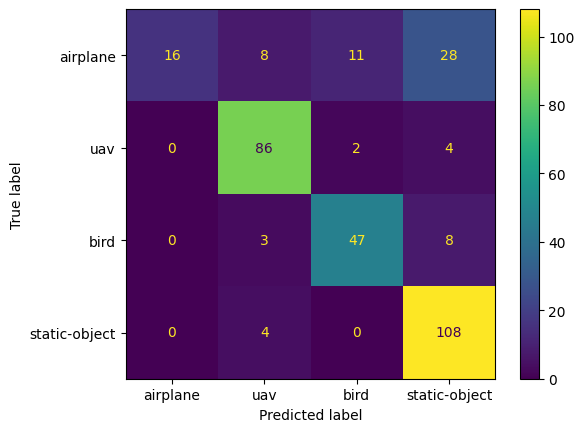

Results for sample duration of 10 sec
{'airplane': {'precision': 1.0, 'recall': 0.24561403508771928, 'f1-score': 0.3943661971830986, 'support': 57}, 'uav': {'precision': 0.8876404494382022, 'recall': 0.8876404494382022, 'f1-score': 0.8876404494382022, 'support': 89}, 'bird': {'precision': 0.6538461538461539, 'recall': 0.7906976744186046, 'f1-score': 0.7157894736842104, 'support': 43}, 'static-object': {'precision': 0.7342657342657343, 'recall': 0.963302752293578, 'f1-score': 0.8333333333333333, 'support': 109}, 'accuracy': 0.7785234899328859, 'macro avg': {'precision': 0.8189380843875226, 'recall': 0.721813727809526, 'f1-score': 0.7077823634097111, 'support': 298}, 'weighted avg': {'precision': 0.8192964753367438, 'recall': 0.7785234899328859, 'f1-score': 0.7486280333597014, 'support': 298}}


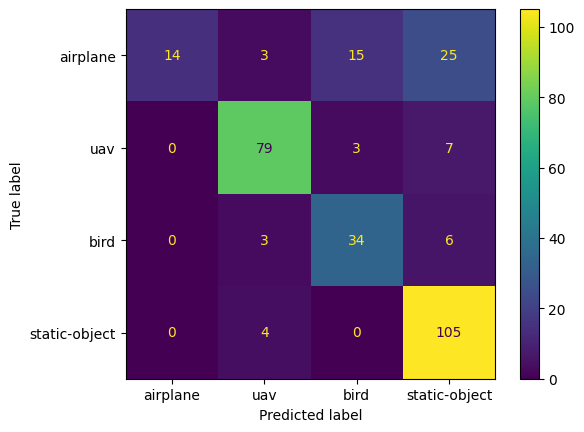

Results for sample duration of 15 sec
{'airplane': {'precision': 1.0, 'recall': 0.34782608695652173, 'f1-score': 0.5161290322580645, 'support': 46}, 'uav': {'precision': 0.9036144578313253, 'recall': 0.872093023255814, 'f1-score': 0.8875739644970415, 'support': 86}, 'bird': {'precision': 0.5909090909090909, 'recall': 0.8387096774193549, 'f1-score': 0.6933333333333334, 'support': 31}, 'static-object': {'precision': 0.8095238095238095, 'recall': 0.9622641509433962, 'f1-score': 0.8793103448275862, 'support': 106}, 'accuracy': 0.8141263940520446, 'macro avg': {'precision': 0.8260118395660565, 'recall': 0.7552232346437717, 'f1-score': 0.7440866687290064, 'support': 269}, 'weighted avg': {'precision': 0.8469834535360581, 'recall': 0.8141263940520446, 'f1-score': 0.7984145959690484, 'support': 269}}


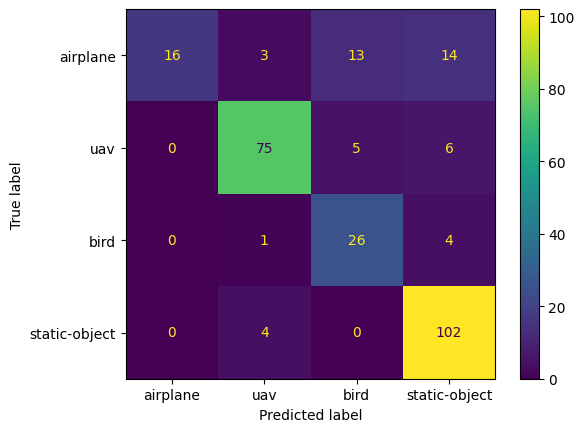

Results for sample duration of 20 sec
{'airplane': {'precision': 1.0, 'recall': 0.34210526315789475, 'f1-score': 0.5098039215686275, 'support': 38}, 'uav': {'precision': 0.9146341463414634, 'recall': 0.9146341463414634, 'f1-score': 0.9146341463414634, 'support': 82}, 'bird': {'precision': 0.625, 'recall': 0.8695652173913043, 'f1-score': 0.7272727272727273, 'support': 23}, 'static-object': {'precision': 0.8260869565217391, 'recall': 0.9595959595959596, 'f1-score': 0.8878504672897197, 'support': 99}, 'accuracy': 0.8388429752066116, 'macro avg': {'precision': 0.8414302757158006, 'recall': 0.7714751466216556, 'f1-score': 0.7598903156181345, 'support': 242}, 'weighted avg': {'precision': 0.8642876392382322, 'recall': 0.8388429752066116, 'f1-score': 0.8223017273081108, 'support': 242}}


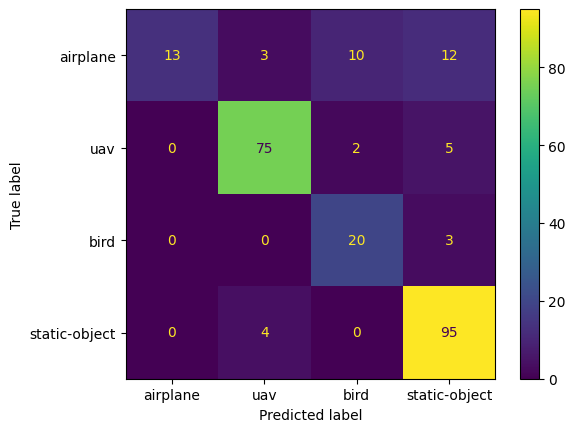

Results for sample duration of 25 sec
{'airplane': {'precision': 1.0, 'recall': 0.2727272727272727, 'f1-score': 0.42857142857142855, 'support': 33}, 'uav': {'precision': 0.9210526315789473, 'recall': 0.8860759493670886, 'f1-score': 0.9032258064516129, 'support': 79}, 'bird': {'precision': 0.5333333333333333, 'recall': 0.8421052631578947, 'f1-score': 0.653061224489796, 'support': 19}, 'static-object': {'precision': 0.8130841121495327, 'recall': 0.9560439560439561, 'f1-score': 0.8787878787878788, 'support': 91}, 'accuracy': 0.8198198198198198, 'macro avg': {'precision': 0.8168675192654533, 'recall': 0.7392381103240531, 'f1-score': 0.715911584575179, 'support': 222}, 'weighted avg': {'precision': 0.8553475019535028, 'recall': 0.8198198198198198, 'f1-score': 0.801241243637557, 'support': 222}}


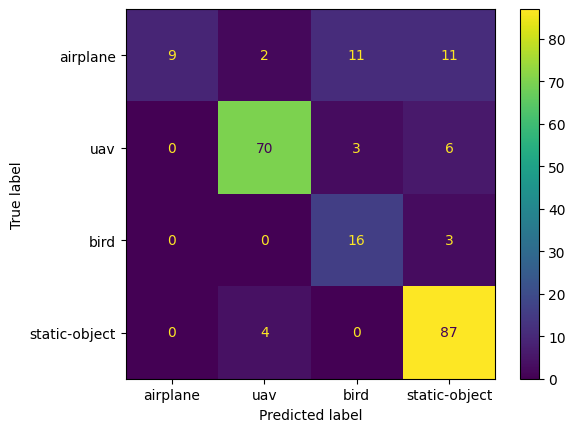

Results for sample duration of 30 sec
{'airplane': {'precision': 1.0, 'recall': 0.32142857142857145, 'f1-score': 0.4864864864864865, 'support': 28}, 'uav': {'precision': 0.9210526315789473, 'recall': 0.9210526315789473, 'f1-score': 0.9210526315789473, 'support': 76}, 'bird': {'precision': 0.42857142857142855, 'recall': 0.6, 'f1-score': 0.5, 'support': 15}, 'static-object': {'precision': 0.8383838383838383, 'recall': 0.9651162790697675, 'f1-score': 0.8972972972972972, 'support': 86}, 'accuracy': 0.8341463414634146, 'macro avg': {'precision': 0.7970019746335535, 'recall': 0.7018993705193215, 'f1-score': 0.7012091038406827, 'support': 205}, 'weighted avg': {'precision': 0.8611199099003978, 'recall': 0.8341463414634146, 'f1-score': 0.8209228740936058, 'support': 205}}


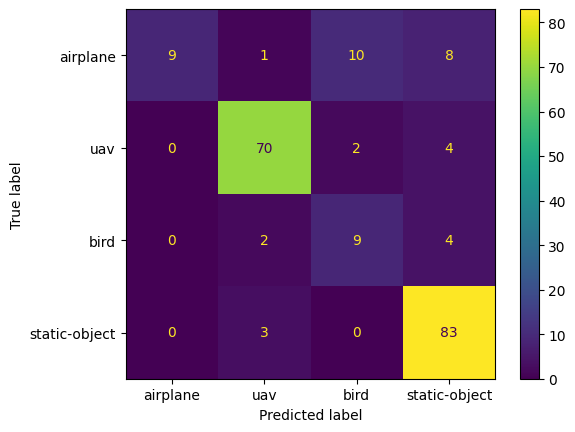

In [ ]:
all_reports = {d:[] for d in durations}
for dur in durations:
  dur_labels = all_test_labels[dur]
  errors = torch.full((len(subf_dict.keys()), len(dur_labels)), torch.inf)
  for f_object, eval_results in evaluation_results.items():
    if len(eval_results[dur]) > 0:
      errors[labels_dict[f_object]] = torch.tensor(eval_results[dur])
  predicted_class = torch.argmin(errors, dim=0)
  report = classification_report(dur_labels, predicted_class, target_names=evaluation_results.keys(), output_dict = True)
  cm = confusion_matrix(dur_labels, predicted_class)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=flying_objects)
  # cm = confusion_matrix(dur_labels, predicted_class, labels=flying_objects)
  all_reports[dur] = report
  print(f'Results for sample duration of {dur} sec')
  print(report)
  disp.plot()
  # disp.ax_.set_title(caption)
  plt.show()

In [ ]:
def plot_training_summary(train_loss_history, eval_loss_history, eval_history, evaluation_durations):
  epochs = np.arange(len(train_loss_history)) + 1
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  ax1.plot(epochs, train_loss_history, 'r', label = 'train loss')
  ax1.plot(epochs, eval_loss_history, 'orange', label = 'eval loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()
  palette = plt.get_cmap('tab20')
  colors = [palette(i) for i in range(len(evaluation_durations))]
  for d, color in zip(evaluation_durations, colors):
    plt.yscale("log")
    ax2.plot(epochs, eval_history[d], color = color, label = d)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Error')
  ax2.legend()

Results for airplane
Results for uav
Results for bird
Results for static-object


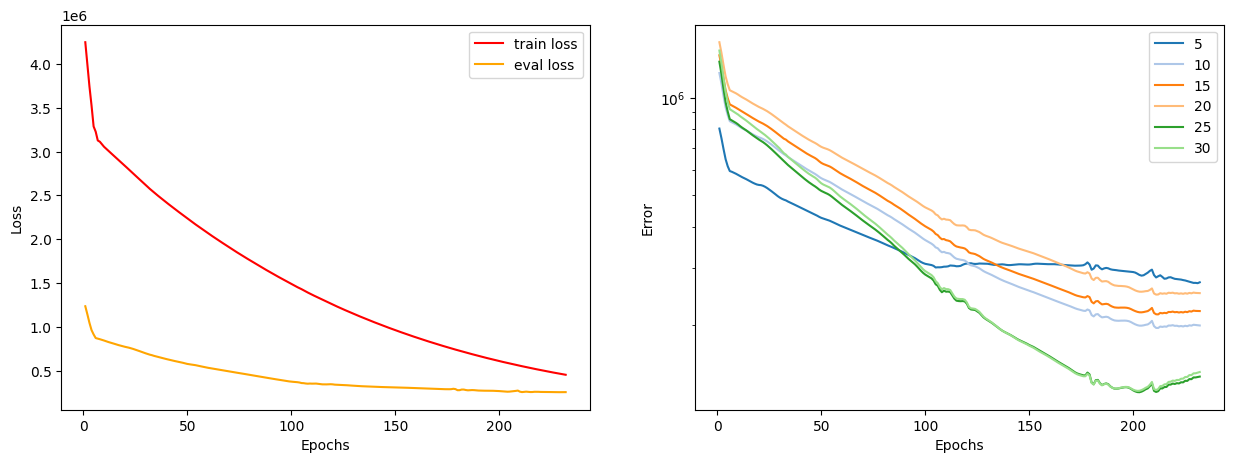

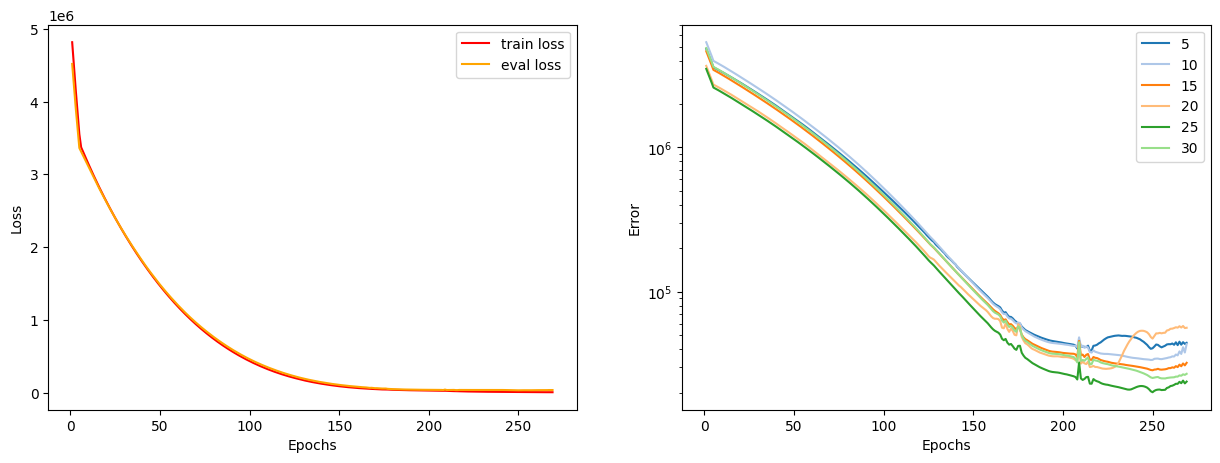

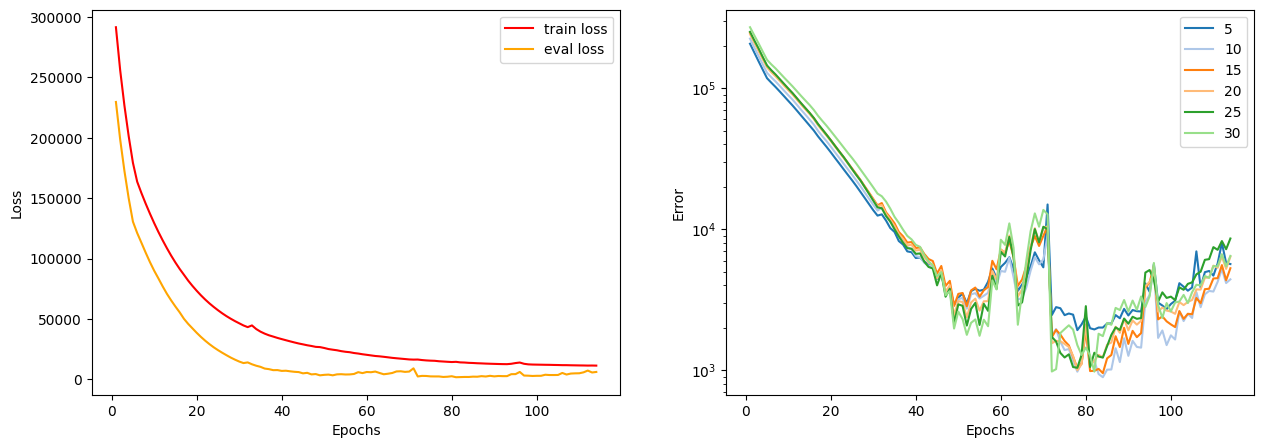

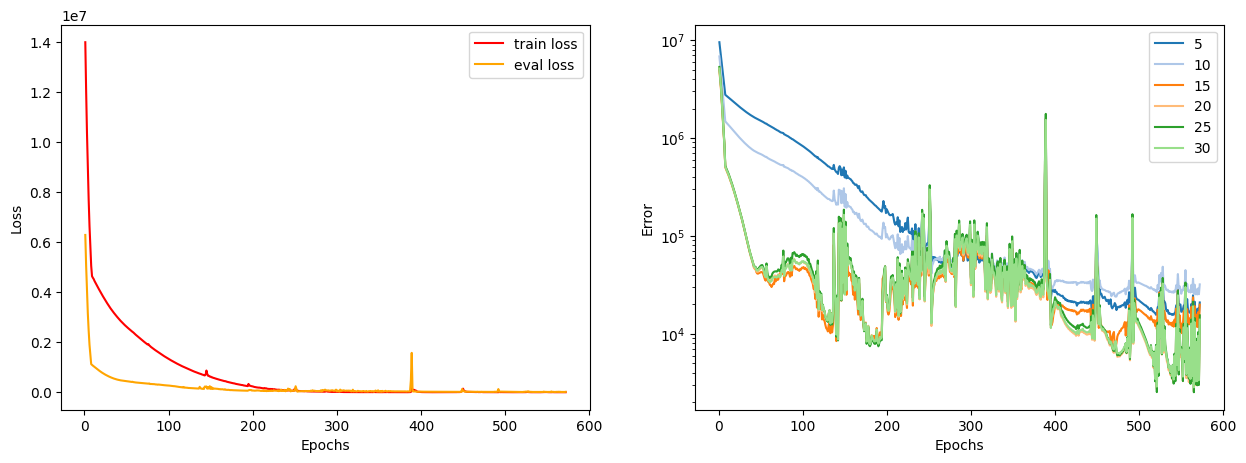

In [ ]:
evaluation_durations =[5, 10, 15, 20, 25, 30]
for f_object, model_path in zip(flying_objects, best_comb):
  train_loss_history = all_results_df[all_results_df['Model Path'] == model_path]['Train Loss History'].values[0]
  eval_loss_history = all_results_df[all_results_df['Model Path'] == model_path]['Evaluation Loss History'].values[0]
  eval_history = all_results_df[all_results_df['Model Path'] == model_path]['Eval History'].values[0]
  print(f'Results for {f_object}')
  plot_training_summary(train_loss_history, eval_loss_history, eval_history, evaluation_durations)

In [ ]:
# summary_df = pd.DataFrame(columns = ['Duration', 'Precision', 'recall', 'f1-score'])
summary_df = pd.DataFrame(columns = ['Duration', 'metric', 'value'])
for d, report in all_reports.items():
  # summary_df = summary_df.append([{'Duration': d, 'Precision': report['uav']['precision'], 'recall': report['uav']['recall'], 'f1-score': report['uav']['f1-score']}])
  summary_df.loc[len(summary_df)] = [d, 'precision', report['uav']['precision']]
  summary_df.loc[len(summary_df)] = [d,'recall', report['uav']['recall']]
  summary_df.loc[len(summary_df)] = [d,'f1-score', report['uav']['f1-score']]
  # ,report['uav']['recall'],report['uav']['f1-score']]


In [ ]:
summary_df

,Duration,metric,value
0,5,precision,0.851485
1,5,recall,0.934783
2,5,f1-score,0.891192
3,10,precision,0.887640
4,10,recall,0.887640
5,10,f1-score,0.887640
6,15,precision,0.903614
7,15,recall,0.872093
8,15,f1-score,0.887574
9,20,precision,0.914634


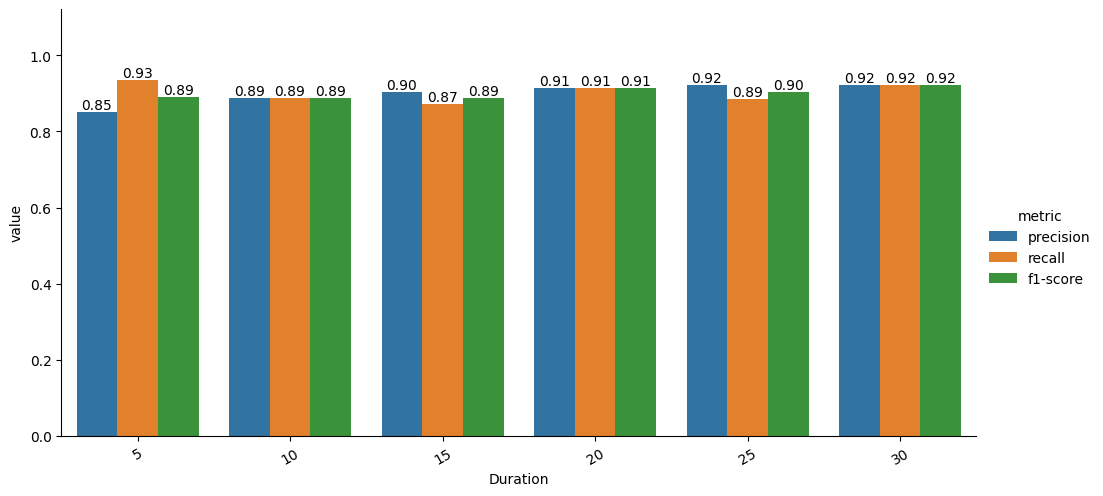

In [ ]:
g = sns.catplot(data=summary_df, x = "Duration", y = "value", hue = "metric", kind="bar", aspect = 2)

for ax in g.axes.ravel():
    for c in ax.containers:
        labels = ['%0.2f' % v for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='edge')
    # plt.xticks(rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.margins(y=0.2)